# 2 Data Checking
10-10-2024

## Env

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sys
import os
from dotenv import load_dotenv

load_dotenv()

True

### Make Database Connection

In [3]:
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy import text

user = "postgres"
password = os.getenv('POSTGRES_PW')
host = "127.0.0.1"
port = "5432"
database = "gradschool"

pg_url = URL.create(
    drivername='postgresql',
    username='postgres',
    host='127.0.0.1',
    database='gradschool',
    password=os.getenv('POSTGRES_PW')
)

pg_engine = create_engine(pg_url)
# Test connection
try:
    with pg_engine.connect() as connection_str:
        print('Successfully connected to the PostgreSQL database')
except Exception as ex:
    print(f'Sorry failed to connect: {ex}')

pg_connection = pg_engine.connect()

Successfully connected to the PostgreSQL database


## Load Tables

In [6]:
# Load all the cleaned datasets directly from PG

# Load Test File of CA bgs
shp_tl_CA_bgs_2020 = gpd.read_postgis(text('SELECT * FROM "mapping_basefiles"."tl_CA_bgs_2020";'), con = pg_connection)

# Slip Lanes
#gdf_tagged_slip_lanes = gpd.read_postgis('select *, geometry as geom from slip_lanes.alameda_tagged_slip_lanes_clean;', con = pg_connection).drop('geometry', axis=1)
gdf_tagged_slip_lanes = gpd.read_postgis('select * from slip_lanes.alameda_tagged_slip_lanes_clean;', con = pg_connection)

# Replica Link Volumes
gdf_network_link_volumes = gpd.read_postgis('select *, geometry as geom from slip_lanes.replica_netlinkvols_alameda_fall2023;', con = pg_connection).drop('geometry', axis=1)

# TIMS/SWITRS Dataset from Oakland/Berkeley
gdf_TIMS = gpd.read_postgis('select *, geometry as geom from slip_lanes.tims_oakberk;', con=pg_connection).drop('geometry', axis = 1)

## Test with Basic Visualization

In [20]:
#gdf_tagged_slip_lanes.groupby('Valid').sum()
gdf_tagged_slip_lanes[gdf_tagged_slip_lanes['Valid']]

,Layer,Name,Description,Active,Is_SlipLane,Has_Questions,o_road,d_road,crdnl_loc,Name_clean,geom,Valid
0,Berkeley Slip Lanes,Ashby Ave -> Adeline St (NE),None,True,True,False,Ashby Ave,Adeline St,NE,Ashby Ave -> Adeline St (NE),POINT Z (-122.26849 37.85507 0),True
1,Berkeley Slip Lanes,Ashby Ave -> Adeline St (SW),None,True,True,False,Ashby Ave,Adeline St,SW,Ashby Ave -> Adeline St (SW),POINT Z (-122.26954 37.85432 0),True
2,Berkeley Slip Lanes,Colusa Ave -> Monterey Ave,None,True,True,False,Colusa Ave,Monterey Ave,None,Colusa Ave -> Monterey Ave,POINT Z (-122.27875 37.88729 0),True
3,Berkeley Slip Lanes,Colusa Ave -> Marin Ave (SE),None,True,True,False,Colusa Ave,Marin Ave,SE,Colusa Ave -> Marin Ave (SE),POINT Z (-122.27873 37.88933 0),True
4,Berkeley Slip Lanes,Del Norte St -> Sutter St,None,True,True,False,Del Norte St,Sutter St,None,Del Norte St -> Sutter St,POINT Z (-122.27229 37.88909 0),True
...,...,...,...,...,...,...,...,...,...,...,...,...
348,Additional Oakland Slip Lanes (from RP),**Mountain Blvd -> Redwood Rd,None,True,True,False,Mountain Blvd,Redwood Rd,None,Mountain Blvd -> Redwood Rd,POINT Z (-122.18301 37.79669 0),True
349,Additional Oakland Slip Lanes (from RP),**Carson St -> Tompkins Ave,None,True,True,False,Carson St,Tompkins Ave,None,Carson St -> Tompkins Ave,POINT Z (-122.18604 37.7899 0),True
350,Additional Oakland Slip Lanes (from RP),**Hawley St -> 73rd Ave,None,True,True,False,Hawley St,73rd Ave,None,Hawley St -> 73rd Ave,POINT Z (-122.19412 37.75456 0),True
351,Additional Oakland Slip Lanes (from RP),**Harbord Dr -> Broadway Terrace,i think we might not consider this slip but ju...,True,True,False,Harbord Dr,Broadway Terrace,None,Harbord Dr -> Broadway Terrace,POINT Z (-122.23627 37.84113 0),True


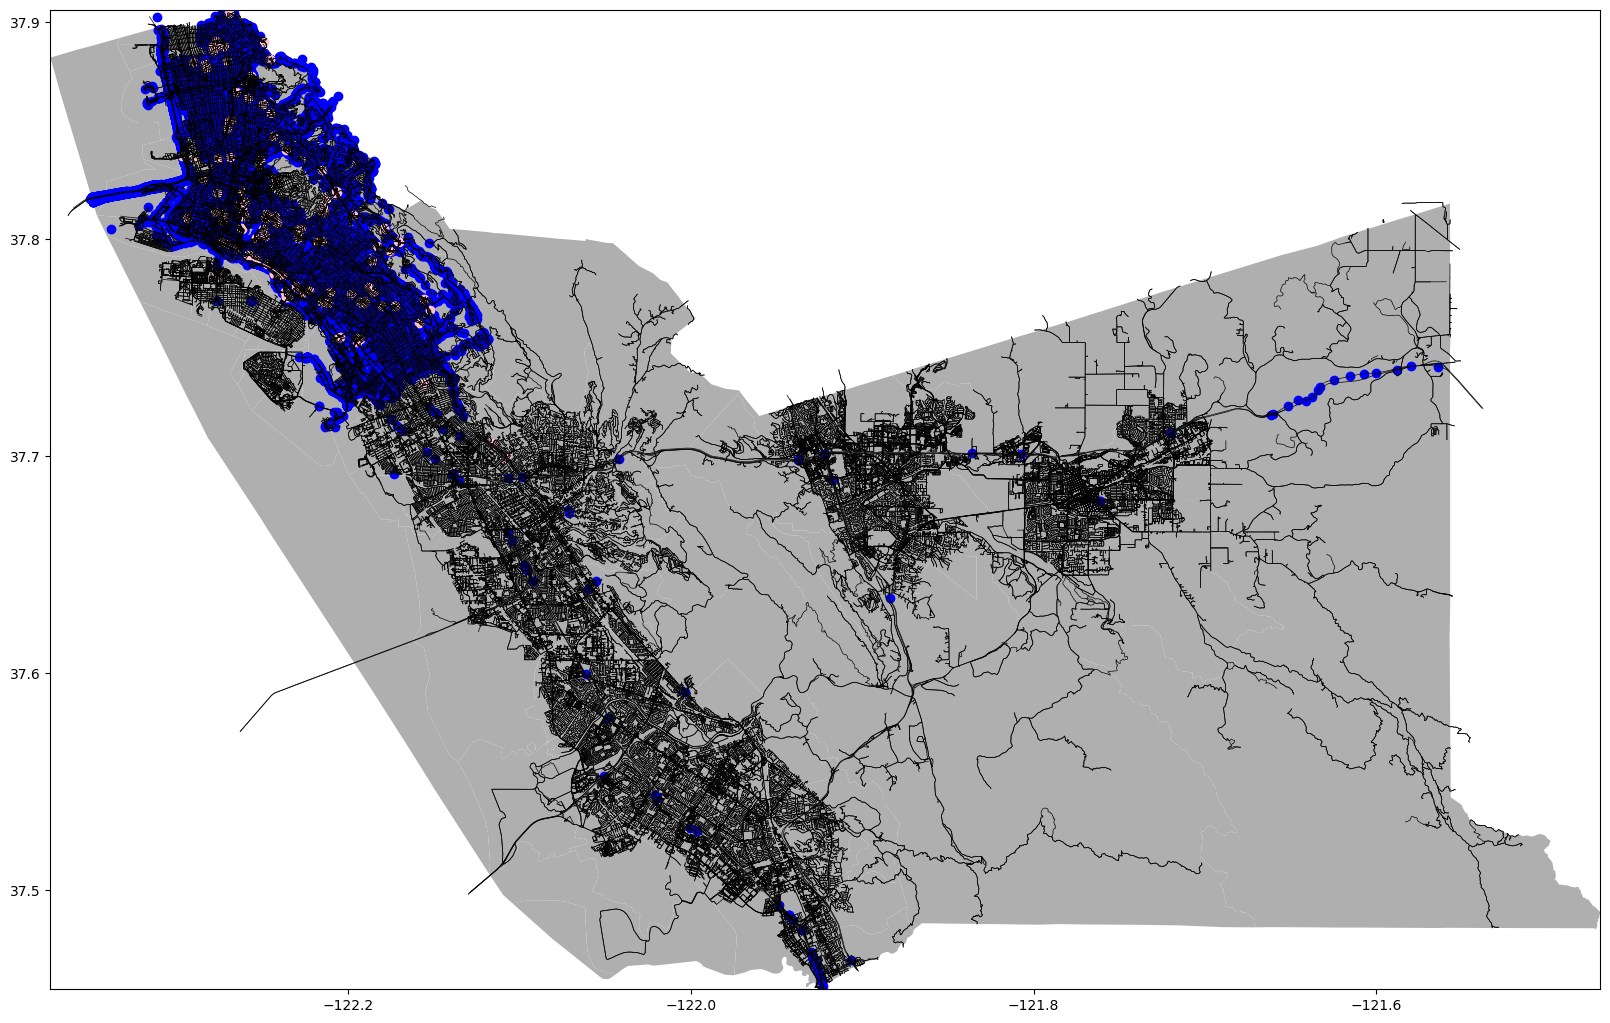

In [22]:
# Basic Pyplot
# Plot them to see how things are aligning so far
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 15))
shp_tl_CA_bgs_2020[shp_tl_CA_bgs_2020['countyfp'] == '001'].plot(ax=ax, color = '#afafaf')
gdf_network_link_volumes.plot(ax=ax, color='#030303', lw = .5)
gdf_TIMS.plot(ax=ax, color = 'blue')
gdf_tagged_slip_lanes[gdf_tagged_slip_lanes['Valid']].plot(ax=ax, color = 'pink')

# Get the extents (bounding box) of the layer
xmin, ymin, xmax, ymax = shp_tl_CA_bgs_2020[shp_tl_CA_bgs_2020['countyfp'] == '001'].total_bounds

# Now Set Extents
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Show the plot
plt.show()


Questions:
- Why are there all the random blue dots in various other areas? I guess those are collisions listed as Oak/Berk that are geo-tagged as elsewhere. That's fine, I think I need to just rely on the geotag.
- Why can't I see the slip lanes? Should I just put them above. Ok now I see them